### Speaker Identity Model- Training

In [324]:
# loading required library
import matplotlib.pyplot as plt
import numpy as np
import librosa
import os
import shutil
import pandas as pd
from keras import models
from keras import layers
import keras
from keras.models import Model
from sklearn.model_selection import train_test_split
import tqdm

In [2]:
import tensorflow as tf
tf.__version__

'2.13.0'

#### About Dataset:
Datasource: https://www.sciencedirect.com/science/article/pii/S2352340922002815
<br>The dataset is used from above resource. The dataset contains total 3000 sample of 150 speakers of Arabic accent and English language. Each speaker's 10 sample digit pronounce and 10 sample of different phrase. Each sample lengths 5-6 seconds.


### Data collection and preprocessing

In [301]:
#base folder of dataset
folder='.\\Speaker Dataset'

#function to get all the file name of all subdirectories of given root directory
def get_file_name(folder_path):
    file_list = []
    y_true = []
    
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_list.append(file)
            y_true.append(int(file.split('-')[0]))
            
    return file_list, y_true

#this function creates train and test folder and distributing file among as per train_test_split
def create_train_test_dir(folder_name, file_list):
    os.mkdir(folder_name)
    for root, dirs, files in os.walk(folder):
        for each_dir in dirs:
            rest = root.split('\\')[2:]
            rest = '\\'.join(rest)
            rest = os.path.join(rest, each_dir)
            rest = os.path.join(folder_name, rest)
            os.mkdir(rest)
            
        for each_file in files:
            if each_file in file_list:
                dest = root.split('\\')[2:]
                dest = '\\'.join(dest)
                dest = os.path.join(folder_name, dest)
                src = os.path.join(root, each_file)
                shutil.copy(src, dest)
    print('All copy done...')
    

##### Train and Test split of dataset file

In [302]:
#shutil.rmtree('Train')
#shutil.rmtree('Test')
file_name, y_data = get_file_name(folder)
train_file, test_file, y_tr, y_test = train_test_split(file_name, y_data, test_size=0.05, stratify=y_data, random_state=42)
create_train_test_dir('Train', train_file)
create_train_test_dir('Test', test_file)

All copy done...
All copy done...


##### Feature Extraction

In [303]:
# this function extracts some basic features of speech of all files of the given root folder
def audio_preprocessing(root_dir):
    header = 'filename chroma_stft rmse spec_cent spec_bw rolloff zcr mfcc lpc label'
    dict_data = {}
    for ftr in header.split():
        if ftr=='mfcc':
            for i in range(1, 21):
                dict_data[ftr+str(i)]=[]
        elif ftr=='chroma_stft':
            for i in range(1, 13):
                dict_data[ftr+str(i)]=[]
        else:
            dict_data[ftr]=[]

    for root, dirs, files in tqdm.tqdm(os.walk(root_dir)):
        for file in files:
            dict_data['filename'].append(file)
            dict_data['label'].append(int(file.split('-')[0]))

            file_loc = os.path.join(root, file)
            y, sr = librosa.load(file_loc, mono=True)
            y, index = librosa.effects.trim(y)

            chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
            chroma_stft = chroma_stft.mean(axis=1)
            for i in range(1, chroma_stft.shape[0]+1):
                dict_data['chroma_stft'+str(i)].append(chroma_stft[i-1])

            rmse = librosa.feature.rms(y=y)
            dict_data['rmse'].append(rmse.mean())

            spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
            dict_data['spec_cent'].append(spec_cent.mean())

            spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
            dict_data['spec_bw'].append(spec_bw.mean())

            rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
            dict_data['rolloff'].append(rolloff.mean())

            zcr = librosa.feature.zero_crossing_rate(y)
            dict_data['zcr'].append(zcr.mean())

            mfcc = librosa.feature.mfcc(y=y, sr=sr)
            mfcc = mfcc.mean(axis=1)
            for i in range(1, mfcc.shape[0]+1):
                dict_data['mfcc'+str(i)].append(mfcc[i-1])

            lpc = librosa.lpc(y=y, order=2)
            
            dict_data['lpc'].append(lpc[1])
    print('Preproessing done..')
    return pd.DataFrame(dict_data)

In [304]:
train_df = audio_preprocessing('.\\Train')
test_df = audio_preprocessing('.\\Test')

303it [16:54,  3.35s/it]
0it [00:00, ?it/s]

Preproessing done..


303it [00:53,  5.64it/s]

Preproessing done..


##### Saving file name of dataset used in training and testing

In [308]:
with open('train file.txt', 'w') as f:
    f.write(str(list(train_df.filename))[1:-1])

In [309]:
with open('test file.txt', 'w') as f:
    f.write(str(list(test_df.filename))[1:-1])

##### Column Standerdization

In [310]:
data_point = train_df.shape[0]
rand_train_df = train_df.sample(data_point)

In [311]:
X_train = rand_train_df.iloc[:, 1:-1].values
y_train = rand_train_df.iloc[:, -1].values

X_test = test_df.iloc[:, 1:-1].values
y_test = test_df.iloc[:, -1].values


print("Y from training data:", y_train.shape)
print("Y from test data:", y_test.shape)

Y from training data: (2850,)
Y from test data: (150,)


In [312]:
#Normalizing the dataset
from sklearn.preprocessing import StandardScaler
import numpy as np
scaler = StandardScaler()
X_train = scaler.fit_transform( X_train )
X_test = scaler.transform( X_test )

print("X from training data", X_train.shape)
print("X from test data", X_test.shape)


X from training data (2850, 38)
X from test data (150, 38)


In [313]:
#saving standard scaler for transforming query data
import pickle
with open('scaler.pkl','wb') as f:
    pickle.dump(scaler, f)

### Model Architecture and training- A Deep Neural Network
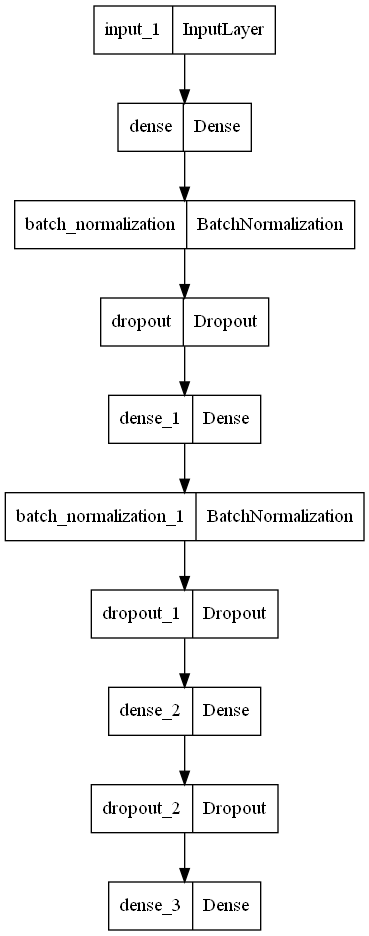

In [316]:
#Creating a Model
from keras import models
from keras import layers
import keras
keras.backend.clear_session()

# model 
input_layer = layers.Input(shape=(38,))
h_layers = layers.Dense(1024, activation='relu')(input_layer)
h_layers = layers.BatchNormalization()(h_layers)
h_layers = layers.Dropout(0.5)(h_layers)
h_layers = layers.Dense(512, activation='relu')(h_layers)
h_layers = layers.BatchNormalization()(h_layers)
h_layers = layers.Dropout(0.3)(h_layers)
h_layers = layers.Dense(256, activation='relu')(h_layers)
h_layers = layers.Dropout(0.3)(h_layers)
output = layers.Dense(151, activation='softmax')(h_layers)

model = Model(inputs=input_layer, outputs=output)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', verbose=0, mode='min')

history = model.fit(X_train,
                    y_train,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=256, 
                    callbacks=[reduce_lr])

Epoch 1/100
9/9 [==============================] - 2s 65ms/step - loss: 4.9993 - accuracy: 0.0447 - val_loss: 4.7174 - val_accuracy: 0.2895 - lr: 0.0010
Epoch 2/100
9/9 [==============================] - 0s 37ms/step - loss: 3.3339 - accuracy: 0.2719 - val_loss: 4.3872 - val_accuracy: 0.4754 - lr: 0.0010
Epoch 3/100
9/9 [==============================] - 0s 39ms/step - loss: 2.2851 - accuracy: 0.5048 - val_loss: 4.0449 - val_accuracy: 0.6596 - lr: 0.0010
Epoch 4/100
9/9 [==============================] - 0s 39ms/step - loss: 1.5609 - accuracy: 0.6711 - val_loss: 3.6887 - val_accuracy: 0.7965 - lr: 0.0010
Epoch 5/100
9/9 [==============================] - 0s 37ms/step - loss: 1.0740 - accuracy: 0.7636 - val_loss: 3.3441 - val_accuracy: 0.8439 - lr: 0.0010
Epoch 6/100
9/9 [==============================] - 0s 42ms/step - loss: 0.7602 - accuracy: 0.8342 - val_loss: 3.0401 - val_accuracy: 0.8281 - lr: 0.0010
Epoch 7/100
9/9 [==============================] - 0s 38ms/step - loss: 0.5623 - a

In [327]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 38)]              0         
                                                                 
 dense (Dense)               (None, 1024)              39936     
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                            

### Model prediction and evaluation

In [320]:
score = model.predict(X_test[122].reshape(-1,38))
print('Speaker: ', np.argmax(score), "Probability: ", score[0,np.argmax(score)])

1/1 [==============================] - 0s 19ms/step
Speaker:  50 Probability:  0.9998073


In [160]:
y_test[19]

136

In [321]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 4ms/step - loss: 0.1171 - accuracy: 0.9600


[0.11714431643486023, 0.9599999785423279]

##### Saved Model for Web API

In [323]:
model.save('./model.h5')

##### Future scope
<ul><li>Unknown speaker has to be handled. 
    <li> Multi Speaker Identity</ul>
 <p>
Facing challanges of collecting multilable speaker dataset. Complexity in speaker diaratization.

### Future Work Ongoing

In [6]:
from pyannote.audio import Model

In [9]:
from huggingface_hub import HfApi
available_models = [m.modelId for m in HfApi().list_models(filter="pyannote-audio-model")]
list(filter(lambda p: p.startswith("pyannote/"), available_models))

['pyannote/TestModelForContinuousIntegration',
 'pyannote/embedding',
 'pyannote/segmentation',
 'pyannote/brouhaha',
 'pyannote/segmentation-3.0',
 'pyannote/wespeaker-voxceleb-resnet34-LM',
 'pyannote/ci-segmentation']

In [10]:
from huggingface_hub import notebook_login
notebook_login()


In [17]:
model = Model.from_pretrained("pyannote/segmentation-3.0", use_auth_token=True)

pytorch_model.bin:   0%|          | 0.00/5.91M [00:00<?, ?B/s]

config.yaml:   0%|          | 0.00/399 [00:00<?, ?B/s]

In [18]:
from pytorch_lightning.utilities.model_summary import summarize

summarize(model)

  | Name       | Type       | Params | In sizes       | Out sizes                                  
---------------------------------------------------------------------------------------------------------
0 | sincnet    | SincNet    | 42.6 K | [1, 1, 160000] | [1, 60, 589]                               
1 | lstm       | LSTM       | 1.4 M  | [1, 589, 60]   | [[1, 589, 256], [[8, 1, 128], [8, 1, 128]]]
2 | linear     | ModuleList | 49.4 K | ?              | ?                                          
3 | classifier | Linear     | 903    | [1, 589, 128]  | [1, 589, 7]                                
4 | activation | LogSoftmax | 0      | [1, 589, 7]    | [1, 589, 7]                                
---------------------------------------------------------------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.893     Total estimated model params size (MB)

In [19]:
specs = model.specifications
specs

Specifications(problem=<Problem.MONO_LABEL_CLASSIFICATION: 1>, resolution=<Resolution.FRAME: 1>, duration=10.0, min_duration=None, warm_up=(0.0, 0.0), classes=['speaker#1', 'speaker#2', 'speaker#3'], powerset_max_classes=2, permutation_invariant=True)

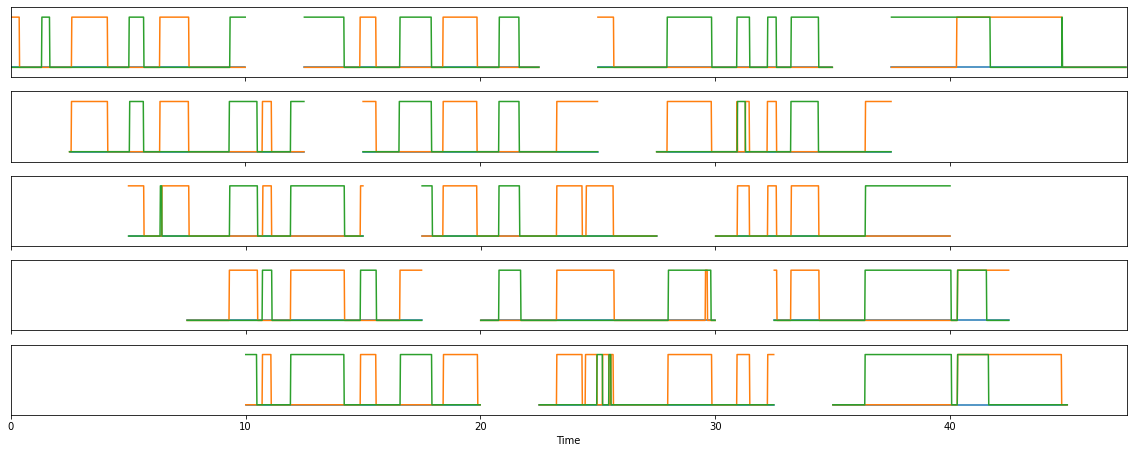

In [21]:
from pyannote.audio import Inference
inference = Inference(model, step=2.5)
output = inference('B_G.wav')
output

In [22]:
output.data.shape

(16, 589, 3)

In [34]:
output.data[0,:,:]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [41]:
import torchaudio
waveform, sample_rate = torchaudio.load('B_G.wav')

print(f"{type(waveform)=}")
print(f"{waveform.shape=}")
print(f"{waveform.dtype=}")

audio_in_memory = {"waveform": waveform, "sample_rate": sample_rate}

type(waveform)=<class 'torch.Tensor'>
waveform.shape=torch.Size([1, 2027012])
waveform.dtype=torch.float32


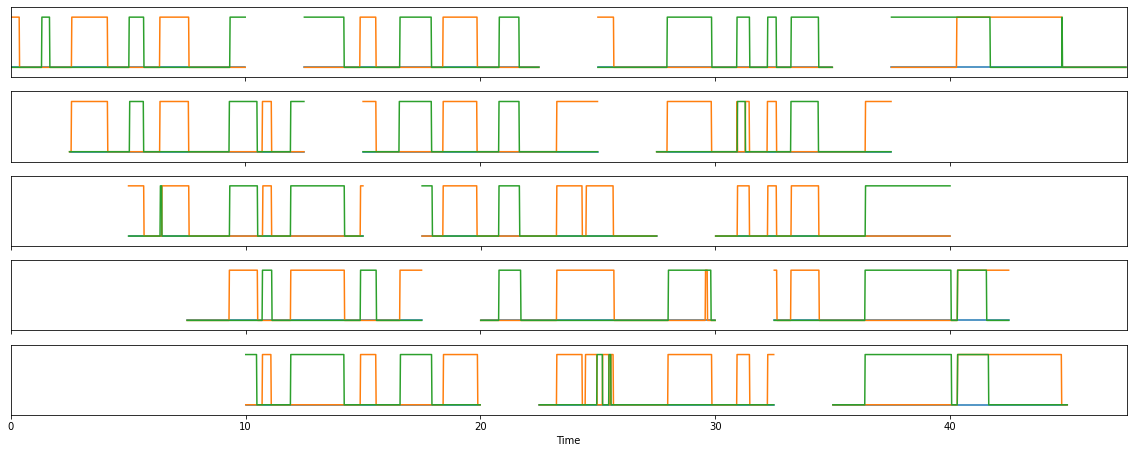

In [42]:
output = inference(audio_in_memory)
output

In [44]:
waveform.shape

torch.Size([1, 2027012])

In [47]:
sample_rate

44100

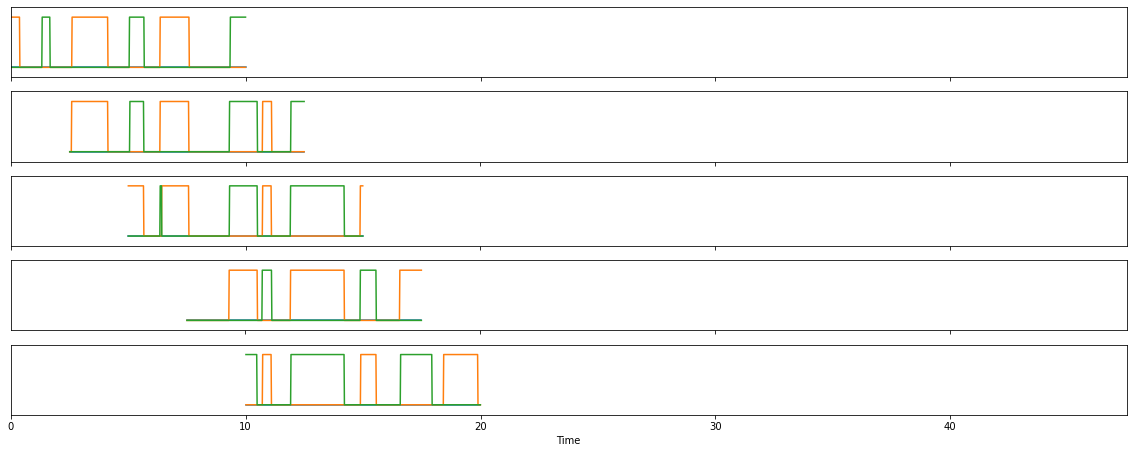

In [48]:
from pyannote.core import Segment
output = inference.crop(audio_in_memory, Segment(0, 20))
output


In [90]:
output.data.mean(axis=1)

array([[0.        , 0.31409168, 0.16298811],
       [0.        , 0.31578946, 0.2359932 ],
       [0.        , 0.23089983, 0.3548387 ],
       [0.        , 0.44312394, 0.10865875],
       [0.        , 0.24957556, 0.4091681 ]], dtype=float32)

In [92]:
from pyannote.audio import Pipeline
pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization-3.1", use_auth_token=True)

config.yaml:   0%|          | 0.00/469 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/26.6M [00:00<?, ?B/s]

config.yaml:   0%|          | 0.00/221 [00:00<?, ?B/s]

In [93]:
dia = pipeline('B_G.wav')

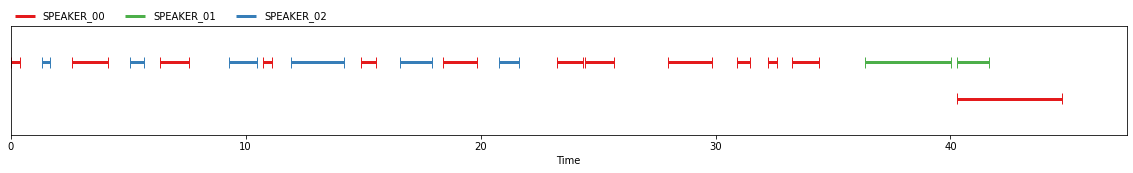

In [94]:
dia

In [102]:
for speech_turn, track, speaker in dia.itertracks(yield_label=True):
    print(f"{speech_turn.start:4.1f} {speech_turn.end:4.1f} {speaker} {track}")

 0.0  0.4 SPEAKER_00 A
 1.3  1.7 SPEAKER_02 B
 2.6  4.1 SPEAKER_00 C
 5.1  5.7 SPEAKER_02 D
 6.4  7.6 SPEAKER_00 E
 9.3 10.5 SPEAKER_02 F
10.7 11.1 SPEAKER_00 G
11.9 14.2 SPEAKER_02 H
14.9 15.5 SPEAKER_00 I
16.6 17.9 SPEAKER_02 J
18.4 19.9 SPEAKER_00 K
20.8 21.7 SPEAKER_02 L
23.3 24.4 SPEAKER_00 M
24.5 25.7 SPEAKER_00 N
28.0 29.8 SPEAKER_00 O
30.9 31.5 SPEAKER_00 P
32.2 32.6 SPEAKER_00 Q
33.2 34.4 SPEAKER_00 R
36.4 40.0 SPEAKER_01 S
40.3 41.6 SPEAKER_01 T
40.3 44.7 SPEAKER_00 U


In [99]:
dia.itertracks(yield_label)

<generator object Annotation.itertracks at 0x000001EEC2EC04A0>